In [1]:
#oneclassSVM since it is not available in cuml,GPU accelerated.
import numpy as np
import pandas as pd
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import joblib  # More efficient for scikit-learn models

# 1. Load and prepare data
data = pd.read_csv("data1.csv")
X = data.drop(columns=["Class",'Time'])
y = data["Class"]

# Map target: normal=1, anomaly=-1 (adjust if needed)
y = y.map({0: 1, 1: -1})  # Example: 0=normal, 1=anomaly

# 2. Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Fit One-Class SVM on majority class (normal, label=1)
X_train_norm = X_train_scaled[y_train == 1]
ocsvm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.05)
ocsvm.fit(X_train_norm)

# 5. Save the trained model and scaler for future use
joblib.dump(ocsvm, "ocsvm_model.joblib")
joblib.dump(scaler, "scaler.joblib")
joblib.dump(X_test_scaled, "X_test_scaled.joblib")
joblib.dump(y_test, "y_test.joblib")




['y_test.joblib']

Best threshold for F0.5-score: 183.1365
Best F0.5-score: 0.4321

==== METRICS AT DEFAULT THRESHOLD ====
Confusion Matrix:
 [[   84    14]
 [ 2970 53894]]
Classification Report:
               precision    recall  f1-score   support

          -1     0.0275    0.8571    0.0533        98
           1     0.9997    0.9478    0.9731     56864

    accuracy                         0.9476     56962
   macro avg     0.5136    0.9025    0.5132     56962
weighted avg     0.9981    0.9476    0.9715     56962

Accuracy: 0.9476
TPR (Recall): 0.9478, FPR: 0.1429

==== METRICS AT BEST F_beta THRESHOLD ====
Confusion Matrix:
 [[   42    56]
 [   55 56809]]
Classification Report:
               precision    recall  f1-score   support

          -1     0.4330    0.4286    0.4308        98
           1     0.9990    0.9990    0.9990     56864

    accuracy                         0.9981     56962
   macro avg     0.7160    0.7138    0.7149     56962
weighted avg     0.9980    0.9981    0.9980     56962


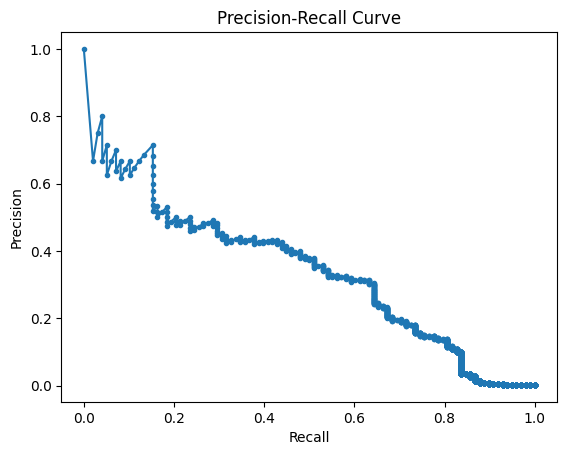

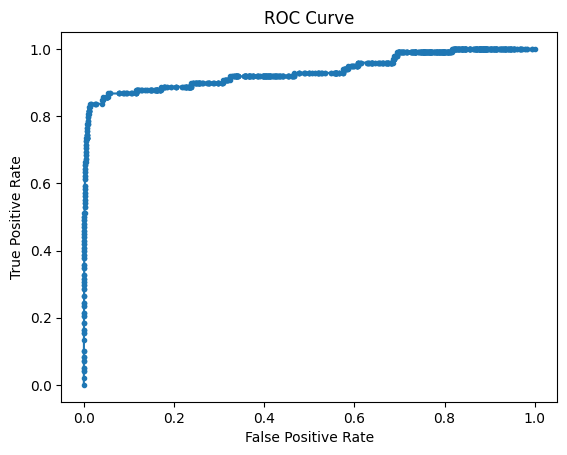

In [2]:
# --- COMMENT ---
# You can now skip training in the future and just load the model, scaler, and test data.
import numpy as np
import joblib
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    precision_recall_curve, roc_curve, roc_auc_score, fbeta_score
)
import matplotlib.pyplot as plt

#  1. Load the trained model, scaler, and test data if needed
#  ocsvm = joblib.load("ocsvm_model.joblib")
#  scaler = joblib.load("scaler.joblib")
#  X_test_scaled = joblib.load("X_test_scaled.joblib")
#  y_test = joblib.load("y_test.joblib")

# 2. Compute decision scores
scores = ocsvm.decision_function(X_test_scaled)

# 3. Default threshold predictions (scikit-learn default is 0)
y_pred_default = ocsvm.predict(X_test_scaled)

# 4. Find best threshold for F-beta score
beta = 0.5  # or 1.0 for F1
precision, recall, pr_thresholds = precision_recall_curve(y_test, -scores, pos_label=-1)
fbeta_scores = []
for thresh in pr_thresholds:
    y_pred_thresh = np.where(-scores >= thresh, -1, 1)
    fbeta_scores.append(fbeta_score(y_test, y_pred_thresh, beta=beta, pos_label=-1))
best_idx = np.argmax(fbeta_scores)
best_thresh = pr_thresholds[best_idx]
print(f"Best threshold for F{beta}-score: {best_thresh:.4f}")
print(f"Best F{beta}-score: {fbeta_scores[best_idx]:.4f}")

# 5. Predictions at best threshold
y_pred_best = np.where(-scores >= best_thresh, -1, 1)

# ---- METRICS AT DEFAULT THRESHOLD ----
print("\n==== METRICS AT DEFAULT THRESHOLD ====")
cm_default = confusion_matrix(y_test, y_pred_default)
print("Confusion Matrix:\n", cm_default)
print("Classification Report:\n", classification_report(y_test, y_pred_default, digits=4))
acc_default = accuracy_score(y_test, y_pred_default)
print(f"Accuracy: {acc_default:.4f}")

tn, fp, fn, tp = cm_default.ravel()
tpr_default = tp / (tp + fn) if (tp + fn) > 0 else 0
fpr_default = fp / (fp + tn) if (fp + tn) > 0 else 0
print(f"TPR (Recall): {tpr_default:.4f}, FPR: {fpr_default:.4f}")

# ---- METRICS AT BEST THRESHOLD ----
print("\n==== METRICS AT BEST F_beta THRESHOLD ====")
cm_best = confusion_matrix(y_test, y_pred_best)
print("Confusion Matrix:\n", cm_best)
print("Classification Report:\n", classification_report(y_test, y_pred_best, digits=4))
acc_best = accuracy_score(y_test, y_pred_best)
print(f"Accuracy: {acc_best:.4f}")

tn_b, fp_b, fn_b, tp_b = cm_best.ravel()
tpr_best = tp_b / (tp_b + fn_b) if (tp_b + fn_b) > 0 else 0
fpr_best = fp_b / (fp_b + tn_b) if (fp_b + tn_b) > 0 else 0
print(f"TPR (Recall): {tpr_best:.4f}, FPR: {fpr_best:.4f}")

# ---- COMMON METRICS (using -scores for anomaly detection) ----
auc_score = roc_auc_score(y_test, -scores)
print(f"\nAUC-ROC: {auc_score:.4f}")

# Precision-Recall Curve
plt.figure()
plt.plot(recall, precision, marker='.')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

# ROC Curve
fpr, tpr, roc_thresholds = roc_curve(y_test, -scores, pos_label=-1)
plt.figure()
plt.plot(fpr, tpr, marker='.')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()
